AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


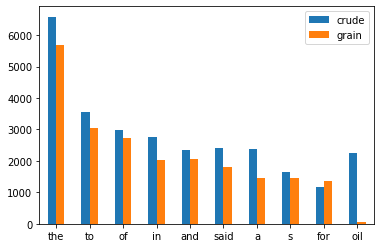

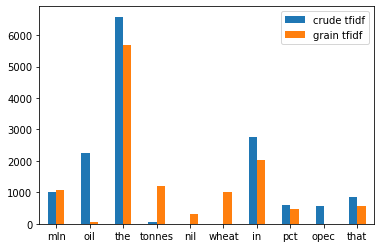

In [4]:
# %load get_words
import os
from os import walk
from os.path import join
import re
import pandas as pd
import numpy as np
import math 
import numpy.random as npr


def get_files(folder1, folder2):
    f = []
    for (root, dirnames, _) in walk('.'):
        for dirname in dirnames:
            if dirname == folder1 or dirname == folder2:
                subfolder = os.path.join(root, dirname)
                for (_, _, filenames) in walk(subfolder):
                    for filename in filenames:
                        f.append(os.path.join(subfolder, filename))
    return f


def get_words(path):
    with open(path, 'r') as article:
        content = article.read().lower()
        words = content.split()
        filtered = [x for x in words if re.match('[a-z]+', x)] # alternative: x.isalpha
        return filtered

def get_word_counts(words):
    word_counts = {}
    unique_words = set(words)
    for word in unique_words:
        word_counts[word] = words.count(word)
    return word_counts

all_files = get_files('grain', 'crude')
all_words=[]
for article in all_files:
    words = get_words(article)
    word_counts=get_word_counts(words)
    all_words.append(word_counts)

all_subfolders=[] 
folder1='crude'
folder2='grain'
for (root, dirnames, f1) in walk('.'): #if grain/crude are in same directory as code, otherwise change expression in 'walk'
    for dirname in dirnames:
        if dirname == folder1 or dirname == folder2: 
            subfolder = os.path.join(root, dirname)
            for (d2, d3, filenames) in walk(subfolder):
                for filename in filenames:
                    all_subfolders.append(subfolder.split('\\')[1])

arrays = [np.asarray(all_files), np.asarray(all_subfolders)]
idx = pd.MultiIndex.from_arrays(arrays, names=('article_name', 'folder_name'))
df = pd.DataFrame(all_words, index=idx)
df = df.fillna(0)
df_sum = df.sum()  #global wordcount 

# delete columns where words occur less than n times in df
n=1
for key, value in df_sum.items():
    if value < n:
        del df[key]

##### PART 2 ######
df_folders = df.sum(level='folder_name') # wordcount per folder
df_top_n = df_sum.nlargest(n=10) #n most used words

word_index = []
crude = []
grain = []
for key, value in df_top_n.items():
    word_index.append(key)
    crude.append(df_folders[key][0])
    grain.append(df_folders[key][1])

df_plot = pd.DataFrame({'crude': crude, 'grain': grain}, index=word_index)
plot = df_plot.plot.bar(rot=0)

##### PART 3
df_tfidf = df.copy()
N = df_tfidf.shape[0] # total amount of documents, alternative: len(df.index)
K = df_tfidf.shape[1] # total amount of articles
d = (df > 0).sum(axis=0) # amount of articles which contain the word

k=0
while k < K: #iterates through every column in df
    a = 0
    while a < N: # iterates through every row in df
        if df_tfidf.iat[a, k] != 0:
            df_tfidf.iat[a, k] = df_tfidf.iat[a, k] * math.log(N/d[k]) #change value in row a, column k to tfidf value
        a=a+1
    k=k+1

#### PART 4
df_tfidf_sum = df_tfidf.sum()
df_tfidf_folders = df_tfidf.sum(level='folder_name') # wordcount per folder
df_tfidf_top_n = df_tfidf_sum.nlargest(n=10) #n most used words

word_index_tfidf = []
crude_tfidf = []
grain_tfidf = []
for key, value in df_tfidf_top_n.items():
     word_index_tfidf.append(key)
     crude_tfidf.append(df_folders[key][0])
     grain_tfidf.append(df_folders[key][1])

df_tfidf_plot = pd.DataFrame({'crude tfidf': crude_tfidf, 'grain tfidf': grain_tfidf}, index=word_index_tfidf)
plot_tfidf = df_tfidf_plot.plot.bar(rot=0)

print(plot)
print(plot_tfidf)